# データの準備

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import json
import time
import glob
from typing import TypeVar, Type, List, Optional
from dataclasses import dataclass
from pydantic import BaseModel
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from openai import AzureOpenAI
from tqdm import tqdm
from typing import List, Dict, Optional, Any, Tuple

In [8]:
folderPath = '/content/drive/MyDrive/00これからの予定/01Yoshihiro輸血DRMA'
os.chdir(folderPath)

In [9]:
csv_files = glob.glob('*.csv')

In [10]:
df = pd.read_csv(csv_files[0])

In [11]:
# Assuming your dataframe is named 'df'
df['included'] = df['notes'].astype(str).str.contains('Included')

In [12]:
df['included'].value_counts()

,count
included,
False,493
True,7


In [13]:
print(f'不一致の数: {df[df["included"] == True]["notes"].str.contains("Excluded").sum()}')

不一致の数: 0


In [14]:
#予測の元となる変数

import json

def create_json_text(row):
    return json.dumps({
        'title': str(row['title']),
        'abstract': str(row['abstract'])
    })

df['tiab'] = df.apply(create_json_text, axis=1)

# APIの準備

# プロトコル上の基準
Inclusion criteria of the articles for the review

Types of studies
We will include randomized controlled trials (RCTs), cluster RCTs, and quasi-randomized, cohort, case-control studies. We will not apply language or country restrictions. We will include all papers including published, unpublished articles, abstracts of conferences, and letters. We will exclude randomized cross-over or case series studies. We will not exclude studies based on the observation period or publication year.  

Inclusion and exclusion criteria
Study
Since we are interested in the association between the amount of transfusion and the acquirement of infection in critically ill patients, we will include studies to evaluate the transfusion for critically ill patients.  

Additionally, since it has reached no consensus whether erythropoietin and iron supplementation affect infection in critically ill patients [4], we will also collect the amounts of transfusion reported in these studies. Whilst, in studies for pharmacotherapy for anemia, we will exclude vitamin D since vitamin D may inhibit sepsis in critically ill patients [5]. For the search for studies of pharmacotherapy for anemia, we will use the search strategies for the systematic review and network meta-analysis to determine the hierarchy of monotherapy and combination therapy to reduce RBC transfusion for patients in the ICU [4].

Population

We will include critically ill adult patients with hemodynamically stable, who are admitted to the ICU. Elective surgical patients and burn patients will be excluded.

Intervention
To evaluate dose-response relationships, it needs that there is the difference of the amount of transfusion between the arms of these studies. Such interventions will be two or more different fixed doses of transfusion within a study and include the no-transfusion group that the amount of transfusion is 0 unit.


Outcome
Incidence of infection
We defined the incidence of infection as healthcare-associated infections (HAIs). HAIs are infections acquired in hospitals where critically ill patients are admitted and newly developed apart from the underlying disease [6]. HAIs cover bacterial, viral, and fungal infections, not parasitic [7]. We will measure the number of patients with HAIs during hospitalization. If the HAIs are not reported, we will collect the ICU-acquired infection. The collected data prioritizes pre-defined infection in each eligible study. In addition, we will collect the category of infection by the following hierarchy: i) Sepsis/Septic shock, ii) Bacteremia, iii) Any infection collected by the original authors.

In [ ]:
from google.colab import userdata

Azure_API_key = userdata.get('Azure_API_key')
RESOURCE_ENDPOINT = userdata.get('RESOURCE_ENDPOINT')

client = AzureOpenAI(
    api_key=Azure_API_key,
    api_version="2024-07-01-preview",
    azure_endpoint=RESOURCE_ENDPOINT
)

In [ ]:
@dataclass
class ScreeningResult:
    judgement: Optional[bool]
    error: Optional[str] = None

class TitleAbstractScreener(BaseModel):
    judgement: bool

def process_abstracts(
    df,
    system_prompt: str,
    client: AzureOpenAI,
    column_name: str = "tiab",
    max_retries: int = 3,
    retry_delay: int = 5,
    model: str = "gpt-4o",
) -> List[ScreeningResult]:
    """
    Process multiple abstracts with retry logic and error handling.

    Args:
        df: DataFrame containing the abstracts
        system_prompt (str): The system prompt for the model
        client (AzureOpenAI): Initialized Azure OpenAI client
        column_name (str): Name of the column containing abstracts
        max_retries (int): Maximum number of retry attempts
        retry_delay (int): Delay between retries in seconds
        model (str): Model deployment name

    Returns:
        List[ScreeningResult]: List of screening results with judgements and any errors
    """
    results: List[ScreeningResult] = []

    # Define tools for function calling
    tools = [{
        "type": "function",
        "function": {
            "name": "abstract_inclusion_decision",
            "description": "Determine if an abstract meets the criteria",
            "parameters": {
                "type": "object",
                "properties": {
                    "judgement": {
                        "type": "boolean",
                        "description": "The judgement of the abstract"
                    }
                },
                "required": ["judgement"]
            }
        }
    }]

    for prompt in df[column_name]:
        result = None
        error_message = None

        for attempt in range(max_retries):
            try:
                # Get structured completion
                screener_result = get_structured_completion(
                    system_prompt=system_prompt,
                    prompt=prompt,
                    client=client,
                    model=model
                )

                # Extract judgement from Pydantic model
                result = screener_result.judgement
                break  # Break the retry loop if successful

            except Exception as e:
                error_message = str(e)
                print(f"Error processing abstract (attempt {attempt+1}/{max_retries}):")
                print(f"Error: {error_message}")

                if attempt < max_retries - 1:
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    print("Max retries reached. Moving to next abstract.")

        # Append result for this abstract
        results.append(ScreeningResult(
            judgement=result,
            error=error_message if result is None else None
        ))

    return results



In [ ]:
system_prompt = """Determine if the input text meets the inclusion criteria.
# Inclusion criteria of the articles for the review

Types of studies
We will include randomized controlled trials (RCTs), cluster RCTs, and quasi-randomized, cohort, case-control studies. We will not apply language or country restrictions. We will include all papers including published, unpublished articles, abstracts of conferences, and letters. We will exclude randomized cross-over or case series studies. We will not exclude studies based on the observation period or publication year.

Inclusion and exclusion criteria
Study
Since we are interested in the association between the amount of transfusion and the acquirement of infection in critically ill patients, we will include studies to evaluate the transfusion for critically ill patients.

Additionally, since it has reached no consensus whether erythropoietin and iron supplementation affect infection in critically ill patients [4], we will also collect the amounts of transfusion reported in these studies. Whilst, in studies for pharmacotherapy for anemia, we will exclude vitamin D since vitamin D may inhibit sepsis in critically ill patients [5]. For the search for studies of pharmacotherapy for anemia, we will use the search strategies for the systematic review and network meta-analysis to determine the hierarchy of monotherapy and combination therapy to reduce RBC transfusion for patients in the ICU [4].

Population

We will include critically ill adult patients with hemodynamically stable, who are admitted to the ICU. Elective surgical patients and burn patients will be excluded.

Intervention
To evaluate dose-response relationships, it needs that there is the difference of the amount of transfusion between the arms of these studies. Such interventions will be two or more different fixed doses of transfusion within a study and include the no-transfusion group that the amount of transfusion is 0 unit.


Outcome
Incidence of infection
We defined the incidence of infection as healthcare-associated infections (HAIs). HAIs are infections acquired in hospitals where critically ill patients are admitted and newly developed apart from the underlying disease [6]. HAIs cover bacterial, viral, and fungal infections, not parasitic [7]. We will measure the number of patients with HAIs during hospitalization. If the HAIs are not reported, we will collect the ICU-acquired infection. The collected data prioritizes pre-defined infection in each eligible study. In addition, we will collect the category of infection by the following hierarchy: i) Sepsis/Septic shock, ii) Bacteremia, iii) Any infection collected by the original authors.

"""

In [ ]:
# Usage example
if __name__ == "__main__":
    results = process_abstracts(
        df=df,
        system_prompt=system_prompt,
        client=client
    )

    # Print summary statistics
    total = len(results)
    successful = sum(1 for r in results if r.judgement is not None)
    failed = total - successful

    print(f"\nProcessing Summary:")
    print(f"Total abstracts processed: {total}")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")

    # Add results to dataframe
    df['screening_judgement'] = [r.judgement for r in results]
    df['screening_error'] = [r.error for r in results]

Error processing abstract (attempt 1/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 3/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Max retries reached. Moving to next abstract.
Error processing abstract (attempt 1/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 3/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Max retries reached. Moving to next abstract.
Error processing abstract (attempt 1/3):
Error


Data types in processed DataFrame:
included               bool
screening_judgement    bool
dtype: object

Unique values in included: [False  True]
Unique values in screening_judgement: [False  True]

Screening Performance Metrics

Confusion Matrix:
True Positive:  1
True Negative:  490
False Positive: 0
False Negative: 6

Performance Metrics:
Sensitivity: 14.29%
Specificity: 100.00%
PPV:         100.00%
NPV:         98.79%
Accuracy:    98.79%

Summary:
Total abstracts evaluated: 497
Abstracts skipped due to errors: 3


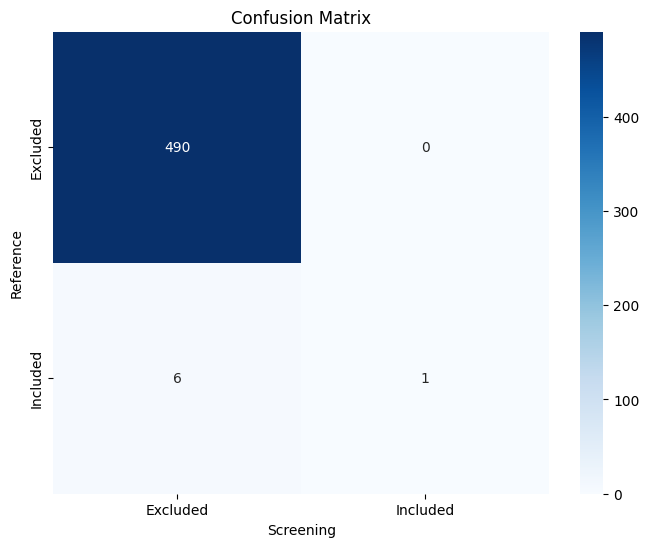

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_screening_metrics(df: pd.DataFrame) -> dict:
    """
    Calculate screening performance metrics including confusion matrix, sensitivity, and specificity.

    Args:
        df: DataFrame containing 'included' (reference) and 'screening_judgement' columns

    Returns:
        dict: Dictionary containing confusion matrix and performance metrics
    """
    # Remove rows where screening_judgement is None (failed screenings)
    valid_df = df.dropna(subset=['included', 'screening_judgement'])

    # Convert both columns to boolean
    valid_df = valid_df.copy()
    valid_df['included'] = valid_df['included'].astype(bool)
    valid_df['screening_judgement'] = valid_df['screening_judgement'].astype(bool)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(
        valid_df['included'],
        valid_df['screening_judgement']
    ).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Create confusion matrix visualization
    plt.figure(figsize=(8, 6))
    cm_display = confusion_matrix(
        valid_df['included'],
        valid_df['screening_judgement']
    )
    sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Excluded', 'Included'],
                yticklabels=['Excluded', 'Included'])
    plt.title('Confusion Matrix')
    plt.ylabel('Reference')
    plt.xlabel('Screening')

    # Create results dictionary
    results = {
        'confusion_matrix': {
            'true_negative': int(tn),
            'false_positive': int(fp),
            'false_negative': int(fn),
            'true_positive': int(tp)
        },
        'metrics': {
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'ppv': float(ppv),
            'npv': float(npv),
            'accuracy': float(accuracy)
        },
        'summary': {
            'total_evaluated': len(valid_df),
            'total_skipped': len(df) - len(valid_df)
        }
    }

    # Print data types for debugging
    print("\nData types in processed DataFrame:")
    print(valid_df[['included', 'screening_judgement']].dtypes)
    print("\nUnique values in included:", valid_df['included'].unique())
    print("Unique values in screening_judgement:", valid_df['screening_judgement'].unique())

    return results

# Usage example
if __name__ == "__main__":
    # Calculate metrics
    results = calculate_screening_metrics(df)

    # Print detailed results
    print("\nScreening Performance Metrics")
    print("=" * 30)

    print("\nConfusion Matrix:")
    print(f"True Positive:  {results['confusion_matrix']['true_positive']}")
    print(f"True Negative:  {results['confusion_matrix']['true_negative']}")
    print(f"False Positive: {results['confusion_matrix']['false_positive']}")
    print(f"False Negative: {results['confusion_matrix']['false_negative']}")

    print("\nPerformance Metrics:")
    print(f"Sensitivity: {results['metrics']['sensitivity']:.2%}")
    print(f"Specificity: {results['metrics']['specificity']:.2%}")
    print(f"PPV:         {results['metrics']['ppv']:.2%}")
    print(f"NPV:         {results['metrics']['npv']:.2%}")
    print(f"Accuracy:    {results['metrics']['accuracy']:.2%}")

    print("\nSummary:")
    print(f"Total abstracts evaluated: {results['summary']['total_evaluated']}")
    print(f"Abstracts skipped due to errors: {results['summary']['total_skipped']}")

    # Show confusion matrix plot
    plt.show()

In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Optional, Any, Tuple
import json
import time
import logging
from datetime import datetime
from tqdm import tqdm

@dataclass
class ScreeningResult:
    judgement: bool
    error: Optional[str] = None

@dataclass
class OptimizationResult:
    prompt: str
    improved_prompt: str
    analysis: str
    suggested_changes: str
    metrics: Dict[str, float]
    error_cases: List[Dict]
    iteration: int
    timestamp: str

class PromptOptimizer:
    def __init__(
        self,
        client,
        base_prompt: str,
        df: pd.DataFrame,
        model: str = "gpt-4",
        max_iterations: int = 50,
        target_sensitivity: float = 1.0,
        target_specificity: float = 0.5,
        save_path: str = None
    ):
        """Initialize the PromptOptimizer."""
        self.client = client
        self.base_prompt = base_prompt
        self.df = df
        self.model = model
        self.max_iterations = max_iterations
        self.target_sensitivity = target_sensitivity
        self.target_specificity = target_specificity
        self.history: List[OptimizationResult] = []

        if save_path is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.save_path = f"prompt_optimization_history_{timestamp}.jsonl"
        else:
            self.save_path = save_path

        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

    def process_abstract(self, text: str, system_prompt: str) -> Optional[bool]:
        """Process a single abstract with retry logic."""
        tools = [{
            "type": "function",
            "function": {
                "name": "abstract_inclusion_decision",
                "description": "Determine if an abstract meets the criteria",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "judgement": {
                            "type": "boolean",
                            "description": "The judgement of the abstract"
                        }
                    },
                    "required": ["judgement"]
                }
            }
        }]

        for attempt in range(3):
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": text}
                    ],
                    tools=tools,
                    tool_choice={"type": "function", "function": {"name": "abstract_inclusion_decision"}}
                )

                if response.choices and response.choices[0].message.tool_calls:
                    function_args = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
                    return function_args.get('judgement')

            except Exception as e:
                print(f"Error processing abstract (attempt {attempt+1}/3):")
                print(f"Error: {str(e)}")
                if attempt < 2:
                    print("Retrying in 5 seconds...")
                    time.sleep(5)

        return None

    def process_batch(self, df: pd.DataFrame, system_prompt: str) -> List[ScreeningResult]:
        """Process a batch of abstracts."""
        results = []
        for _, row in df.iterrows():
            result = self.process_abstract(row.get('tiab', ''), system_prompt)
            results.append(ScreeningResult(
                judgement=False if result is None else result
            ))
        return results

    def evaluate_metrics(self, df_results: pd.DataFrame) -> Dict[str, float]:
        """Calculate performance metrics."""
        # Convert screening_judgement to boolean, treating None as True (include)
        df_results['screening_judgement'] = df_results['screening_judgement'].fillna(True)

        valid_df = df_results.dropna(subset=['included', 'screening_judgement'])
        y_true = valid_df['included'].astype(bool)
        y_pred = valid_df['screening_judgement'].astype(bool)

        tp = sum((y_true == True) & (y_pred == True))
        tn = sum((y_true == False) & (y_pred == False))
        fp = sum((y_true == False) & (y_pred == True))
        fn = sum((y_true == True) & (y_pred == False))

        return {
            'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'accuracy': (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        }

    def analyze_errors(self, df_results: pd.DataFrame) -> List[Dict]:
        """Analyze and sample error cases."""
        df_analysis = df_results.copy()
        df_analysis['result_type'] = 'correct'

        fp_mask = (~df_analysis['included']) & (df_analysis['screening_judgement'])
        fn_mask = (df_analysis['included']) & (~df_analysis['screening_judgement'])

        df_analysis.loc[fp_mask, 'result_type'] = 'false_positive'
        df_analysis.loc[fn_mask, 'result_type'] = 'false_negative'

        error_cases = []
        for result_type in ['false_positive', 'false_negative']:
            error_df = df_analysis[df_analysis['result_type'] == result_type]
            if len(error_df) > 0:
                sampled_errors = error_df.sample(n=min(5, len(error_df)))
                for _, row in sampled_errors.iterrows():
                    error_cases.append({
                        'type': result_type,
                        'title': row['title'],
                        'abstract': row['abstract'],
                        'should_be': 'included' if row['included'] else 'excluded',
                        'was': 'included' if row['screening_judgement'] else 'excluded'
                    })
        return error_cases

    def improve_prompt(self, current_prompt: str, metrics: Dict[str, float],
                      error_cases: List[Dict]) -> Optional[Dict[str, str]]:
        """Improve the current prompt using GPT-4."""
        tools = [{
            "type": "function",
            "function": {
                "name": "prompt_improvement",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "analysis": {"type": "string"},
                        "suggested_changes": {"type": "string"},
                        "improved_prompt": {"type": "string"}
                    },
                    "required": ["analysis", "suggested_changes", "improved_prompt"]
                }
            }
        }]

        error_summary = self._format_error_summary(error_cases)
        evaluation_message = self._create_evaluation_message(current_prompt, metrics, error_summary)

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "あなたはsystematic reviewのためのabstract screeningを行うシステムプロンプトの評価・改善の専門家です。"},
                    {"role": "user", "content": evaluation_message}
                ],
                tools=tools,
                tool_choice={"type": "function", "function": {"name": "prompt_improvement"}}
            )

            if not response.choices or not response.choices[0].message.tool_calls:
                return None

            return json.loads(response.choices[0].message.tool_calls[0].function.arguments)

        except Exception as e:
            logging.error(f"Error improving prompt: {str(e)}")
            return None

    def _format_error_summary(self, error_cases: List[Dict]) -> str:
        """Format error cases summary."""
        total_fp = len([case for case in error_cases if case['type'] == 'false_positive'])
        total_fn = len([case for case in error_cases if case['type'] == 'false_negative'])

        summary = f"\nError Cases Analysis (FP: {total_fp}, FN: {total_fn}):\n"
        for error_type in ['false_negative', 'false_positive']:
            type_cases = [case for case in error_cases if case['type'] == error_type]
            if type_cases:
                summary += f"\n{error_type.upper()} CASES:\n"
                for i, case in enumerate(type_cases, 1):
                    summary += (f"\nCase {i}:\nTitle: {case['title']}\n"
                              f"Abstract: {case['abstract']}\n"
                              f"Should be: {case['should_be']}, Was: {case['was']}\n")
        return summary

    def _create_evaluation_message(self, prompt: str, metrics: Dict[str, float],
                                 error_summary: str) -> str:
        """Create the evaluation message for prompt improvement."""
        return (
            f"現在のプロンプトの評価結果:\n"
            f"感度: {metrics['sensitivity']:.2%}\n"
            f"特異度: {metrics['specificity']:.2%}\n"
            f"正確度: {metrics['accuracy']:.2%}\n\n"
            f"現在のプロンプト:\n{prompt}\n"
            f"{error_summary}\n"
            "重要: 以下の点を考慮してプロンプトを改善してください：\n"
            "1. 偽陰性を完全になくし、感度を100%にする\n"
            "2. 特異度を50%以上に保つ\n"
            "3. エラーケースに対して適切に対応できるよう、基準を明確化する\n"
            "4. 特に偽陰性のケースを重点的に分析し、取りこぼしを防ぐ"
        )

    def save_result(self, result: OptimizationResult):
        """Save optimization result to file."""
        try:
            with open(self.save_path, 'a', encoding='utf-8') as f:
                json_record = {
                    'timestamp': result.timestamp,
                    'iteration': result.iteration,
                    'prompt': result.prompt,
                    'analysis': result.analysis,
                    'suggested_changes': result.suggested_changes,
                    'metrics': result.metrics,
                    'error_cases': result.error_cases
                }
                f.write(json.dumps(json_record, ensure_ascii=False) + '\n')
            logging.info(f"Saved result for iteration {result.iteration}")
        except Exception as e:
            logging.error(f"Error saving result: {str(e)}")

    def optimize(self) -> Tuple[str, Dict[str, float], List[Dict]]:
        """Main optimization loop."""
        current_prompt = self.base_prompt
        best_metrics = {'sensitivity': 0, 'specificity': 0, 'accuracy': 0}
        best_prompt = current_prompt
        best_error_cases = []

        with tqdm(total=self.max_iterations, desc="Optimizing prompt") as pbar:
            for iteration in range(self.max_iterations):
                try:
                    results = self.process_batch(self.df, current_prompt)

                    df_results = self.df.copy()
                    df_results['screening_judgement'] = [r.judgement for r in results]

                    metrics = self.evaluate_metrics(df_results)
                    error_cases = self.analyze_errors(df_results)

                    pbar.set_description(
                        f"Optimizing | "
                        f"Sens: {metrics['sensitivity']:.2%}, "
                        f"Spec: {metrics['specificity']:.2%}, "
                        f"Acc: {metrics['accuracy']:.2%}"
                    )

                    if (metrics['sensitivity'] >= self.target_sensitivity and
                        metrics['specificity'] >= self.target_specificity):
                        logging.info("Target metrics achieved!")
                        return current_prompt, metrics, error_cases

                    if self._is_better_result(metrics, best_metrics):
                        best_metrics = metrics
                        best_prompt = current_prompt
                        best_error_cases = error_cases

                    improvement = self.improve_prompt(current_prompt, metrics, error_cases)
                    if improvement:
                        self._handle_improvement(improvement, current_prompt, metrics,
                                              error_cases, iteration)
                        current_prompt = improvement['improved_prompt']

                    pbar.update(1)
                    time.sleep(2)

                except Exception as e:
                    logging.error(f"Error in iteration {iteration + 1}: {str(e)}")
                    break

        logging.info("Maximum iterations reached")
        return best_prompt, best_metrics, best_error_cases

    def _is_better_result(self, current: Dict[str, float], best: Dict[str, float]) -> bool:
        """Determine if current metrics are better than best metrics."""
        return (current['sensitivity'] > best['sensitivity'] or
                (current['sensitivity'] == best['sensitivity'] and
                 current['specificity'] > best['specificity']))

    def _handle_improvement(self, improvement: Dict[str, str], current_prompt: str,
                          metrics: Dict[str, float], error_cases: List[Dict],
                          iteration: int):
        """Handle the improvement result."""
        result = OptimizationResult(
            prompt=current_prompt,
            improved_prompt=improvement['improved_prompt'],
            analysis=improvement.get('analysis', ''),
            suggested_changes=improvement.get('suggested_changes', ''),
            metrics=metrics,
            error_cases=error_cases,
            iteration=iteration,
            timestamp=datetime.now().isoformat()
        )
        self.history.append(result)
        self.save_result(result)

In [ ]:
random_df = df.sample(n=250, random_state=42)

In [ ]:
if __name__ == "__main__":
    optimizer = PromptOptimizer(
        client=client,
        base_prompt=system_prompt,
        df=random_df,
        model="gpt-4o",  # または使用するモデル名
        max_iterations=50,
        target_sensitivity=1.0,
        target_specificity=0.5,
        save_path=None  # 自動的にタイムスタンプ付きのファイル名が生成されます
    )
    print("Starting prompt optimization...")
    optimized_prompt, final_metrics, final_errors = optimizer.optimize()

    print("\nOptimization completed!")
    print(f"\nFinal metrics:")
    print(f"Sensitivity: {final_metrics['sensitivity']:.2%}")
    print(f"Specificity: {final_metrics['specificity']:.2%}")
    print(f"Accuracy: {final_metrics['accuracy']:.2%}")

    print(f"\nNumber of remaining error cases: {len(final_errors)}")

    # エラーケースの種類ごとの数を表示
    fn_count = len([e for e in final_errors if e['type'] == 'false_negative'])
    fp_count = len([e for e in final_errors if e['type'] == 'false_positive'])
    print(f"False Negatives: {fn_count}")
    print(f"False Positives: {fp_count}")

    print("\nOptimization history has been saved to:", optimizer.save_path)

    print("\nOptimized Prompt:")
    print(optimized_prompt)

Starting prompt optimization...




Optimizing prompt:   0%|          | 0/50 [00:00<?, ?it/s]

Error processing abstract (attempt 1/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content



Optimizing | Sens: 0.00%, Spec: 100.00%, Acc: 98.80%:   0%|          | 0/50 [02:41<?, ?it/s]

Optimizing prompt | Sensitivity: 0.00%, Specificity: 100.00%, Accuracy: 100.00%:   4%|▍         | 2/50 [3:30:20<84:08:04, 6310.09s/it]
Optimizing prompt | Sensitivity: 0.00%, Specificity: 100.00%, Accuracy: 100.00%:   2%|▏         | 1/50 [3:21:39<164:41:00, 12099.20s/it]
Optimizing prompt | Sensitivity: 0.00%, Specificity: 95.00%, Accuracy: 95.00%:  22%|██▏       | 11/50 [3:17:15<11:39:20, 1075.91s/it]


Error processing abstract (attempt 1/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content



Optimizing | Sens: 33.33%, Spec: 100.00%, Acc: 99.20%:   2%|▏         | 1/50 [05:37<2:25:04, 177.64s/it]

Optimizing | Sens: 33.33%, Spec: 100.00%, Acc: 99.20%:   4%|▍         | 2/50 [05:48<2:19:00, 173.77s/it]

Error processing abstract (attempt 1/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content



Optimizing | Sens: 66.67%, Spec: 99.60%, Acc: 99.20%:   4%|▍         | 2/50 [08:16<2:19:00, 173.77s/it] 

Optimizing | Sens: 66.67%, Spec: 99.60%, Acc: 99.20%:   6%|▌         | 3/50 [08:28<2:10:57, 167.19s/it]

Error processing abstract (attempt 1/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content



Optimizing | Sens: 100.00%, Spec: 97.57%, Acc: 97.60%:   6%|▌         | 3/50 [11:20<2:57:38, 226.78s/it]


Optimization completed!

Final metrics:
Sensitivity: 100.00%
Specificity: 97.57%
Accuracy: 97.60%

Number of remaining error cases: 5
False Negatives: 0
False Positives: 5

Optimization history has been saved to: prompt_optimization_history_20241205_074516.jsonl

Optimized Prompt:
Determine if the input text meets the refined inclusion criteria. # Refined Inclusion Criteria for the Systematic Review: ## Types of Studies - Include randomized controlled trials, cluster RCTs, quasi-randomized trials, cohort, case-control, and prospective observational studies. - Language, country, publication status, and year of publication do not restrict inclusion. - Exclude randomized cross-over or case series studies. ## Study Focus - The study must examine any aspect of red blood cell transfusion in critically ill patients, including trauma and cardiac arrest scenarios if related to transfusion strategies or outcomes. This encompasses evaluating transfusion triggers, protocols, or decision support s

# 残りのでも問題ないかを確認

In [ ]:
# サンプリングされなかった行のインデックスを取得する方法
remaining_df = df[~df.index.isin(random_df.index)]

In [ ]:
# Usage example
if __name__ == "__main__":
    results = process_abstracts(
        df=remaining_df,
        system_prompt=optimized_prompt,
        client=client
    )

    # Print summary statistics
    total = len(results)
    successful = sum(1 for r in results if r.judgement is not None)
    failed = total - successful

    print(f"\nProcessing Summary:")
    print(f"Total abstracts processed: {total}")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")

    # Add results to dataframe
    remaining_df['screening_judgement'] = [r.judgement for r in results]
    remaining_df['screening_error'] = [r.error for r in results]

Error processing abstract (attempt 1/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 3/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Max retries reached. Moving to next abstract.
Error processing abstract (attempt 1/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 2/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Retrying in 5 seconds...
Error processing abstract (attempt 3/3):
Error: ScreeningResult.__init__() missing 1 required positional argument: 'judgement'
Max retries reached. Moving to next abstract.

Processing Summary:
Total abstracts processed

<ipython-input-156-88c44e6bd347>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df['screening_judgement'] = [r.judgement for r in results]
<ipython-input-156-88c44e6bd347>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df['screening_error'] = [r.error for r in results]



Data types in processed DataFrame:
included               bool
screening_judgement    bool
dtype: object

Unique values in included: [False  True]
Unique values in screening_judgement: [False  True]

Screening Performance Metrics

Confusion Matrix:
True Positive:  1
True Negative:  239
False Positive: 5
False Negative: 3

Performance Metrics:
Sensitivity: 25.00%
Specificity: 97.95%
PPV:         16.67%
NPV:         98.76%
Accuracy:    96.77%

Summary:
Total abstracts evaluated: 248
Abstracts skipped due to errors: 2


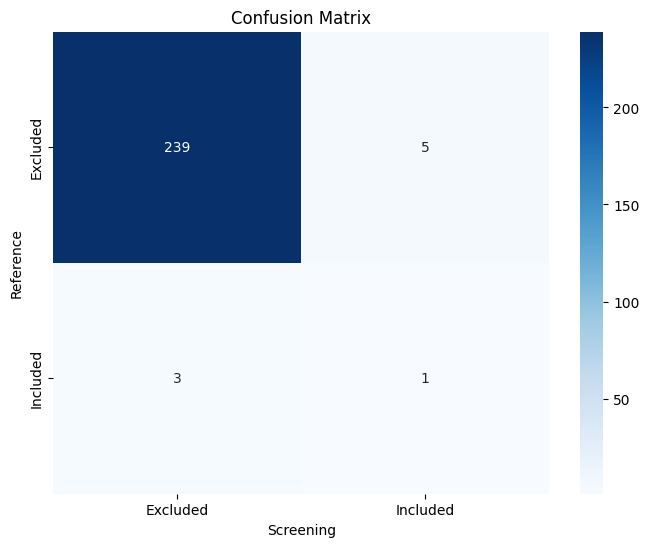

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Usage example
if __name__ == "__main__":
    # Calculate metrics
    results = calculate_screening_metrics(remaining_df)

    # Print detailed results
    print("\nScreening Performance Metrics")
    print("=" * 30)

    print("\nConfusion Matrix:")
    print(f"True Positive:  {results['confusion_matrix']['true_positive']}")
    print(f"True Negative:  {results['confusion_matrix']['true_negative']}")
    print(f"False Positive: {results['confusion_matrix']['false_positive']}")
    print(f"False Negative: {results['confusion_matrix']['false_negative']}")

    print("\nPerformance Metrics:")
    print(f"Sensitivity: {results['metrics']['sensitivity']:.2%}")
    print(f"Specificity: {results['metrics']['specificity']:.2%}")
    print(f"PPV:         {results['metrics']['ppv']:.2%}")
    print(f"NPV:         {results['metrics']['npv']:.2%}")
    print(f"Accuracy:    {results['metrics']['accuracy']:.2%}")

    print("\nSummary:")
    print(f"Total abstracts evaluated: {results['summary']['total_evaluated']}")
    print(f"Abstracts skipped due to errors: {results['summary']['total_skipped']}")

    # Show confusion matrix plot
    plt.show()

# 2024-12-06　普通の機械学習に

In [2]:
!pip install sentence-transformers optuna lightgbm open_clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.4 MB/s eta 0:00:00


In [15]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import optuna
from lightgbm import LGBMClassifier

def prepare_text_data(df, text_column='tiab', label_column='included'):
    """テキストデータの前処理とTF-IDF変換"""
    texts = df[text_column].fillna('')

    vectorizer = TfidfVectorizer(
        max_features=10000,
        min_df=2,
        max_df=0.95,
        ngram_range=(1, 2)
    )

    X_vec = vectorizer.fit_transform(texts)
    y = df[label_column]

    class_weights = dict(zip(
        y.unique(),
        [1 / (len(y) * (y == label).mean()) for label in y.unique()]
    ))

    return X_vec, y, vectorizer, class_weights

def fbeta_score_custom(y_true, y_pred, beta=1):
    """カスタムF-betaスコアの計算"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if precision == 0.0 and recall == 0.0:
        return 0.0
    fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return fbeta

def calculate_detailed_metrics(y_true, y_pred):
    """詳細な評価指標の計算と表示"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    print("\n=== 詳細な評価指標 ===")
    print(f"感度 (Sensitivity/Recall): {sensitivity:.3f}")
    print(f"特異度 (Specificity): {specificity:.3f}")
    print(f"適合率 (Precision): {precision:.3f}")
    print(f"F1スコア: {f1:.3f}")

    print("\n=== 混同行列 ===")
    print("                  Predicted")
    print("                  Negative  Positive")
    print(f"Actual Negative    {tn:^8} {fp:^8}")
    print(f"      Positive    {fn:^8} {tp:^8}")

    return {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    }

def evaluate_model(X_vec, y, params, threshold, class_weights, beta=2):
    """モデルの評価（交差検証）"""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    all_predictions = []
    all_true_values = []

    for train_idx, val_idx in skf.split(X_vec, y):
        X_tr = X_vec[train_idx]
        X_val = X_vec[val_idx]
        y_tr = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        model = LGBMClassifier(
            **params,
            random_state=42,
            class_weight=class_weights
        )

        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        score = fbeta_score_custom(y_val, y_pred, beta=beta)
        scores.append(score)

        all_predictions.extend(y_pred)
        all_true_values.extend(y_val)

    if len(scores) == 5:
        print("\n=== 交差検証全体の評価 ===")
        metrics = calculate_detailed_metrics(all_true_values, all_predictions)
        print("\nClassification Report:")
        print(classification_report(all_true_values, all_predictions))

    return np.mean(scores)

def objective(trial, X_vec, y, class_weights, beta=2):
    """Optunaの目的関数"""
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "verbosity": -1
    }
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    score = evaluate_model(X_vec, y, params, threshold, class_weights, beta=beta)
    return score

def train_final_model(df, beta_value=2, n_trials=50):
    """完全なトレーニングパイプライン"""
    # データの準備
    X_vec, y, vectorizer, class_weights = prepare_text_data(df)

    print(f"データセットの形状: {X_vec.shape}")
    print(f"クラスの分布:\n{y.value_counts(normalize=True)}")
    print(f"クラスの重み: {class_weights}")

    # ハイパーパラメータの最適化
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, X_vec, y, class_weights, beta=beta_value),
        n_trials=n_trials
    )

    best_params = study.best_trial.params
    threshold = best_params.pop("threshold")

    print("\nBest parameters:", best_params)
    print("Best threshold:", threshold)

    final_score = evaluate_model(X_vec, y, best_params, threshold, class_weights, beta=beta_value)
    print(f"\nFinal Mean F{beta_value} Score:", final_score)

    # 最終モデルの学習
    final_model = LGBMClassifier(
        **best_params,
        random_state=42,
        class_weight=class_weights
    )
    final_model.fit(X_vec, y)

    # 最終評価
    print("\n=== 最終モデルの評価（全データ） ===")
    y_prob = final_model.predict_proba(X_vec)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    final_metrics = calculate_detailed_metrics(y, y_pred)

    return final_model, vectorizer, threshold, best_params

def predict_new_text(text, model, vectorizer, threshold):
    """新しいテキストの予測"""
    X_new = vectorizer.transform([text])
    prob = model.predict_proba(X_new)[0, 1]
    prediction = prob >= threshold
    return prediction, prob



In [22]:
# 使用例
if __name__ == "__main__":
    # データの読み込み
    #df = pd.read_csv('your_data.csv')  # tiab列とincluded列を含むデータ

    # モデルのトレーニング
    model, vectorizer, threshold, best_params = train_final_model(
        df,
        beta_value=5,  # より高い値で再現率を重視
        n_trials=50
    )

    # 新しいテキストでの予測例
    new_text = "新しい論文のタイトルと要約"
    prediction, probability = predict_new_text(new_text, model, vectorizer, threshold)
    print(f"\n予測結果: {'含める' if prediction else '含めない'}")
    print(f"確信度: {probability:.3f}")

[I 2024-12-06 03:47:20,049] A new study created in memory with name: no-name-4ec2adb2-8dde-4599-b4f8-e75b76c89726


データセットの形状: (500, 10000)
クラスの分布:
included
False    0.986
True     0.014
Name: proportion, dtype: float64
クラスの重み: {False: 0.002028397565922921, True: 0.14285714285714285}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:20,992] Trial 0 finished with


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:21,246] Trial 1 finished with


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:21,770] Trial 2 finished with


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:22,128] Trial 3 finished with


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:22,629] Trial 4 finished with


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 03:47:23,104] Trial 5 finished with value: 0.18420062695924763 and parameters: {'num_leaves': 16, 'learning_rate': 0.0309442822666318, 'n_estimators': 222, 'reg_lambda': 0.07418248213856618, 'min_child_samples': 70, 'threshold': 0.26383393489266044}. Best is trial 1 with value: 0.2634666666666667.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.286
特異度 (Specificity): 0.905
適合率 (Precision): 0.041
F1スコア: 0.071

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      446       47   
      Positive       5        2    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.90      0.94       493
        True       0.04      0.29      0.07         7

    accuracy                           0.90       500
   macro avg       0.51      0.60      0.51       500
weighted avg       0.98      0.90      0.93       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:24,283] Trial 6 finished with


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 03:47:24,944] Trial 7 finished with value: 0.09285714285714286 and parameters: {'num_leaves': 115, 'learning_rate': 0.05243013026039743, 'n_estimators': 233, 'reg_lambda': 0.09159643113641246, 'min_child_samples': 61, 'threshold': 0.16197245731822385}. Best is trial 1 with value: 0.2634666666666667.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.143
特異度 (Specificity): 0.927
適合率 (Precision): 0.027
F1スコア: 0.045

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      457       36   
      Positive       6        1    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.93      0.96       493
        True       0.03      0.14      0.05         7

    accuracy                           0.92       500
   macro avg       0.51      0.53      0.50       500
weighted avg       0.97      0.92      0.94       500



[I 2024-12-06 03:47:26,239] Trial 8 finished with value: 0.09811320754716982 and parameters: {'num_leaves': 49, 'learning_rate': 0.0025084944417734455, 'n_estimators': 233, 'reg_lambda': 0.0328350076364971, 'min_child_samples': 11, 'threshold': 0.6011480678579981}. Best is trial 1 with value: 0.2634666666666667.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.143
特異度 (Specificity): 0.974
適合率 (Precision): 0.071
F1スコア: 0.095

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      480       13   
      Positive       6        1    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       493
        True       0.07      0.14      0.10         7

    accuracy                           0.96       500
   macro avg       0.53      0.56      0.54       500
weighted avg       0.97      0.96      0.97       500



[I 2024-12-06 03:47:26,677] Trial 9 finished with value: 0.1 and parameters: {'num_leaves': 106, 'learning_rate': 0.12583682934611048, 'n_estimators': 333, 'reg_lambda': 0.002666869218719604, 'min_child_samples': 93, 'threshold': 0.13864102081280016}. Best is trial 1 with value: 0.2634666666666667.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.143
特異度 (Specificity): 0.992
適合率 (Precision): 0.200
F1スコア: 0.167

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      489       4    
      Positive       6        1    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       493
        True       0.20      0.14      0.17         7

    accuracy                           0.98       500
   macro avg       0.59      0.57      0.58       500
weighted avg       0.98      0.98      0.98       500



[I 2024-12-06 03:47:27,288] Trial 10 finished with value: 0.40889188568732615 and parameters: {'num_leaves': 77, 'learning_rate': 0.008831022756975036, 'n_estimators': 446, 'reg_lambda': 1.715165565173574, 'min_child_samples': 99, 'threshold': 0.4239145772577494}. Best is trial 10 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.627
適合率 (Precision): 0.032
F1スコア: 0.061

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      309      184   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.63      0.77       493
        True       0.03      0.86      0.06         7

    accuracy                           0.63       500
   macro avg       0.51      0.74      0.42       500
weighted avg       0.98      0.63      0.76       500



[I 2024-12-06 03:47:27,806] Trial 11 finished with value: 0.40889188568732615 and parameters: {'num_leaves': 78, 'learning_rate': 0.009492102851397993, 'n_estimators': 490, 'reg_lambda': 1.4948166605521875, 'min_child_samples': 95, 'threshold': 0.425866585557906}. Best is trial 10 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.627
適合率 (Precision): 0.032
F1スコア: 0.061

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      309      184   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.63      0.77       493
        True       0.03      0.86      0.06         7

    accuracy                           0.63       500
   macro avg       0.51      0.74      0.42       500
weighted avg       0.98      0.63      0.76       500



[I 2024-12-06 03:47:28,471] Trial 12 finished with value: 0.4524267694082564 and parameters: {'num_leaves': 79, 'learning_rate': 0.01077727391751566, 'n_estimators': 499, 'reg_lambda': 1.6238392078571762, 'min_child_samples': 84, 'threshold': 0.4683186759030179}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.700
適合率 (Precision): 0.039
F1スコア: 0.075

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      345      148   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.70      0.82       493
        True       0.04      0.86      0.07         7

    accuracy                           0.70       500
   macro avg       0.52      0.78      0.45       500
weighted avg       0.98      0.70      0.81       500



[I 2024-12-06 03:47:29,081] Trial 13 finished with value: 0.23294117647058826 and parameters: {'num_leaves': 79, 'learning_rate': 0.01810249279149569, 'n_estimators': 497, 'reg_lambda': 0.6211575722886941, 'min_child_samples': 77, 'threshold': 0.446273576403028}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.429
特異度 (Specificity): 0.819
適合率 (Precision): 0.033
F1スコア: 0.061

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      404       89   
      Positive       4        3    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.82      0.90       493
        True       0.03      0.43      0.06         7

    accuracy                           0.81       500
   macro avg       0.51      0.62      0.48       500
weighted avg       0.98      0.81      0.89       500



[I 2024-12-06 03:47:29,669] Trial 14 finished with value: 0.21349593495934957 and parameters: {'num_leaves': 83, 'learning_rate': 0.07827173448481131, 'n_estimators': 411, 'reg_lambda': 8.377467960607698, 'min_child_samples': 80, 'threshold': 0.5707365316521319}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.429
特異度 (Specificity): 0.803
適合率 (Precision): 0.030
F1スコア: 0.056

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      396       97   
      Positive       4        3    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.80      0.89       493
        True       0.03      0.43      0.06         7

    accuracy                           0.80       500
   macro avg       0.51      0.62      0.47       500
weighted avg       0.98      0.80      0.88       500



[I 2024-12-06 03:47:30,327] Trial 15 finished with value: 0.0 and parameters: {'num_leaves': 42, 'learning_rate': 0.00908387938737356, 'n_estimators': 407, 'reg_lambda': 0.3566439527144589, 'min_child_samples': 86, 'threshold': 0.7156216603471612}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 0.970
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      478       15   
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       493
        True       0.00      0.00      0.00         7

    accuracy                           0.96       500
   macro avg       0.49      0.48      0.49       500
weighted avg       0.97      0.96      0.96       500



[I 2024-12-06 03:47:31,426] Trial 16 finished with value: 0.0 and parameters: {'num_leaves': 124, 'learning_rate': 0.027418228836626958, 'n_estimators': 416, 'reg_lambda': 0.3931852087935584, 'min_child_samples': 33, 'threshold': 0.4005024108931293}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 0.957
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      472       21   
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       493
        True       0.00      0.00      0.00         7

    accuracy                           0.94       500
   macro avg       0.49      0.48      0.49       500
weighted avg       0.97      0.94      0.96       500



[I 2024-12-06 03:47:32,188] Trial 17 finished with value: 0.0 and parameters: {'num_leaves': 68, 'learning_rate': 0.2371745137710781, 'n_estimators': 338, 'reg_lambda': 1.6912187515401027, 'min_child_samples': 61, 'threshold': 0.5130863397114741}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 0.980
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      483       10   
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       493
        True       0.00      0.00      0.00         7

    accuracy                           0.97       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.97      0.97      0.97       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:32,696] Trial 18 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 03:47:33,139] Trial 19 finished with value: 0.37942997779209164 and parameters: {'num_leaves': 39, 'learning_rate': 0.007584331542343614, 'n_estimators': 365, 'reg_lambda': 0.24740206266205697, 'min_child_samples': 100, 'threshold': 0.3466587876942845}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.578
適合率 (Precision): 0.028
F1スコア: 0.054

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      285      208   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.58      0.73       493
        True       0.03      0.86      0.05         7

    accuracy                           0.58       500
   macro avg       0.51      0.72      0.39       500
weighted avg       0.98      0.58      0.72       500



[I 2024-12-06 03:47:33,769] Trial 20 finished with value: 0.20807926829268295 and parameters: {'num_leaves': 68, 'learning_rate': 0.016904166092011567, 'n_estimators': 438, 'reg_lambda': 1.0412970779042665, 'min_child_samples': 88, 'threshold': 0.5364522851474304}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.429
特異度 (Specificity): 0.815
適合率 (Precision): 0.032
F1スコア: 0.059

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      402       91   
      Positive       4        3    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.82      0.89       493
        True       0.03      0.43      0.06         7

    accuracy                           0.81       500
   macro avg       0.51      0.62      0.48       500
weighted avg       0.98      0.81      0.88       500



[I 2024-12-06 03:47:34,283] Trial 21 finished with value: 0.40889188568732615 and parameters: {'num_leaves': 80, 'learning_rate': 0.010073787647901681, 'n_estimators': 482, 'reg_lambda': 2.34890064495925, 'min_child_samples': 92, 'threshold': 0.44438295572793374}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.627
適合率 (Precision): 0.032
F1スコア: 0.061

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      309      184   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.63      0.77       493
        True       0.03      0.86      0.06         7

    accuracy                           0.63       500
   macro avg       0.51      0.74      0.42       500
weighted avg       0.98      0.63      0.76       500



[I 2024-12-06 03:47:34,760] Trial 22 finished with value: 0.348825529974926 and parameters: {'num_leaves': 81, 'learning_rate': 0.011403820885407418, 'n_estimators': 458, 'reg_lambda': 3.2502682492299737, 'min_child_samples': 100, 'threshold': 0.4041056514966084}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.225
適合率 (Precision): 0.018
F1スコア: 0.035

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      111      382   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.23      0.37       493
        True       0.02      1.00      0.04         7

    accuracy                           0.24       500
   macro avg       0.51      0.61      0.20       500
weighted avg       0.99      0.24      0.36       500



[I 2024-12-06 03:47:35,399] Trial 23 finished with value: 0.23419117647058824 and parameters: {'num_leaves': 73, 'learning_rate': 0.03095839863786021, 'n_estimators': 383, 'reg_lambda': 0.9443394913752252, 'min_child_samples': 75, 'threshold': 0.4510556999216998}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.429
特異度 (Specificity): 0.826
適合率 (Precision): 0.034
F1スコア: 0.062

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      407       86   
      Positive       4        3    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.83      0.90       493
        True       0.03      0.43      0.06         7

    accuracy                           0.82       500
   macro avg       0.51      0.63      0.48       500
weighted avg       0.98      0.82      0.89       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:35,933] Trial 24 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 03:47:36,564] Trial 25 finished with value: 0.0 and parameters: {'num_leaves': 101, 'learning_rate': 0.0032966911699548055, 'n_estimators': 459, 'reg_lambda': 0.18886380074265638, 'min_child_samples': 62, 'threshold': 0.6334873049813962}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 0.963
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      475       18   
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       493
        True       0.00      0.00      0.00         7

    accuracy                           0.95       500
   macro avg       0.49      0.48      0.49       500
weighted avg       0.97      0.95      0.96       500



[I 2024-12-06 03:47:37,195] Trial 26 finished with value: 0.07647058823529412 and parameters: {'num_leaves': 90, 'learning_rate': 0.049194453113771595, 'n_estimators': 304, 'reg_lambda': 1.1582649009034531, 'min_child_samples': 94, 'threshold': 0.4778088228984885}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.143
特異度 (Specificity): 0.850
適合率 (Precision): 0.013
F1スコア: 0.024

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      419       74   
      Positive       6        1    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.85      0.91       493
        True       0.01      0.14      0.02         7

    accuracy                           0.84       500
   macro avg       0.50      0.50      0.47       500
weighted avg       0.97      0.84      0.90       500



[I 2024-12-06 03:47:37,769] Trial 27 finished with value: 0.08387096774193549 and parameters: {'num_leaves': 86, 'learning_rate': 0.01584696374715083, 'n_estimators': 441, 'reg_lambda': 0.16522591797929123, 'min_child_samples': 84, 'threshold': 0.3824336085298018}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.143
特異度 (Specificity): 0.880
適合率 (Precision): 0.017
F1スコア: 0.030

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      434       59   
      Positive       6        1    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.88      0.93       493
        True       0.02      0.14      0.03         7

    accuracy                           0.87       500
   macro avg       0.50      0.51      0.48       500
weighted avg       0.97      0.87      0.92       500



[I 2024-12-06 03:47:38,488] Trial 28 finished with value: 0.3097922312556459 and parameters: {'num_leaves': 71, 'learning_rate': 0.006860796441280616, 'n_estimators': 379, 'reg_lambda': 0.6684645351012269, 'min_child_samples': 67, 'threshold': 0.5315237408267364}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.571
特異度 (Specificity): 0.769
適合率 (Precision): 0.034
F1スコア: 0.064

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      379      114   
      Positive       3        4    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.77      0.87       493
        True       0.03      0.57      0.06         7

    accuracy                           0.77       500
   macro avg       0.51      0.67      0.47       500
weighted avg       0.98      0.77      0.86       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:39,156] Trial 29 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 03:47:40,079] Trial 30 finished with value: 0.0 and parameters: {'num_leaves': 61, 'learning_rate': 0.022356999374895818, 'n_estimators': 293, 'reg_lambda': 0.01376185619932879, 'min_child_samples': 29, 'threshold': 0.21728890335226048}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 0.984
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      485       8    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       493
        True       0.00      0.00      0.00         7

    accuracy                           0.97       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.97      0.97      0.97       500



[I 2024-12-06 03:47:40,767] Trial 31 finished with value: 0.40889188568732615 and parameters: {'num_leaves': 77, 'learning_rate': 0.011985789533809259, 'n_estimators': 488, 'reg_lambda': 2.2665939730954796, 'min_child_samples': 94, 'threshold': 0.4454888735793544}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.627
適合率 (Precision): 0.032
F1スコア: 0.061

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      309      184   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.63      0.77       493
        True       0.03      0.86      0.06         7

    accuracy                           0.63       500
   macro avg       0.51      0.74      0.42       500
weighted avg       0.98      0.63      0.76       500



[I 2024-12-06 03:47:41,363] Trial 32 finished with value: 0.4524267694082564 and parameters: {'num_leaves': 87, 'learning_rate': 0.011073367313105513, 'n_estimators': 472, 'reg_lambda': 4.103618539269833, 'min_child_samples': 93, 'threshold': 0.48768197693086346}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.700
適合率 (Precision): 0.039
F1スコア: 0.075

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      345      148   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.70      0.82       493
        True       0.04      0.86      0.07         7

    accuracy                           0.70       500
   macro avg       0.52      0.78      0.45       500
weighted avg       0.98      0.70      0.81       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:42,067] Trial 33 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:42,624] Trial 34 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 03:47:43,200] Trial 35 finished with value: 0.4083755645889792 and parameters: {'num_leaves': 65, 'learning_rate': 0.0054981724946928335, 'n_estimators': 473, 'reg_lambda': 0.5920370887194087, 'min_child_samples': 99, 'threshold': 0.4923180650647255}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.714
特異度 (Specificity): 0.736
適合率 (Precision): 0.037
F1スコア: 0.070

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      363      130   
      Positive       2        5    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.74      0.85       493
        True       0.04      0.71      0.07         7

    accuracy                           0.74       500
   macro avg       0.52      0.73      0.46       500
weighted avg       0.98      0.74      0.84       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:43,904] Trial 36 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:44,391] Trial 37 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:44,869] Trial 38 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:45,656] Trial 39 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 1.000
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      493       0    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 03:47:46,259] Trial 40 finished with value: 0.25328821339193064 and parameters: {'num_leaves': 73, 'learning_rate': 0.007558688853542099, 'n_estimators': 449, 'reg_lambda': 0.43732797958570424, 'min_child_samples': 69, 'threshold': 0.22058510059831515}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.213
適合率 (Precision): 0.015
F1スコア: 0.030

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      105      388   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.21      0.35       493
        True       0.02      0.86      0.03         7

    accuracy                           0.22       500
   macro avg       0.50      0.54      0.19       500
weighted avg       0.98      0.22      0.35       500



[I 2024-12-06 03:47:46,884] Trial 41 finished with value: 0.40889188568732615 and parameters: {'num_leaves': 85, 'learning_rate': 0.008772567295428248, 'n_estimators': 472, 'reg_lambda': 2.5212017805205478, 'min_child_samples': 95, 'threshold': 0.4350801042351762}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.627
適合率 (Precision): 0.032
F1スコア: 0.061

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      309      184   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.63      0.77       493
        True       0.03      0.86      0.06         7

    accuracy                           0.63       500
   macro avg       0.51      0.74      0.42       500
weighted avg       0.98      0.63      0.76       500



[I 2024-12-06 03:47:47,407] Trial 42 finished with value: 0.4524267694082564 and parameters: {'num_leaves': 75, 'learning_rate': 0.01092936218421836, 'n_estimators': 484, 'reg_lambda': 2.3680968329260588, 'min_child_samples': 91, 'threshold': 0.4724534350097304}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.700
適合率 (Precision): 0.039
F1スコア: 0.075

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      345      148   
      Positive       1        6    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.70      0.82       493
        True       0.04      0.86      0.07         7

    accuracy                           0.70       500
   macro avg       0.52      0.78      0.45       500
weighted avg       0.98      0.70      0.81       500



[I 2024-12-06 03:47:47,950] Trial 43 finished with value: 0.09122807017543859 and parameters: {'num_leaves': 76, 'learning_rate': 0.040992703605995, 'n_estimators': 425, 'reg_lambda': 0.8707619438533408, 'min_child_samples': 80, 'threshold': 0.487533941922122}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.143
特異度 (Specificity): 0.907
適合率 (Precision): 0.021
F1スコア: 0.037

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      447       46   
      Positive       6        1    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.91      0.95       493
        True       0.02      0.14      0.04         7

    accuracy                           0.90       500
   macro avg       0.50      0.52      0.49       500
weighted avg       0.97      0.90      0.93       500



[I 2024-12-06 03:47:48,594] Trial 44 finished with value: 0.0962962962962963 and parameters: {'num_leaves': 95, 'learning_rate': 0.019676748675254874, 'n_estimators': 485, 'reg_lambda': 5.391600638738399, 'min_child_samples': 97, 'threshold': 0.5719309857193537}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.143
特異度 (Specificity): 0.862
適合率 (Precision): 0.014
F1スコア: 0.026

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      425       68   
      Positive       6        1    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.86      0.92       493
        True       0.01      0.14      0.03         7

    accuracy                           0.85       500
   macro avg       0.50      0.50      0.47       500
weighted avg       0.97      0.85      0.91       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 03:47:49,063] Trial 45 finished wit


=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.000
適合率 (Precision): 0.014
F1スコア: 0.028

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative       0       493   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 03:47:49,467] Trial 46 finished with value: 0.20029629629629628 and parameters: {'num_leaves': 63, 'learning_rate': 0.0132908698555121, 'n_estimators': 259, 'reg_lambda': 3.0506822937690545, 'min_child_samples': 86, 'threshold': 0.5431418445426099}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.286
特異度 (Specificity): 0.824
適合率 (Precision): 0.022
F1スコア: 0.042

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      406       87   
      Positive       5        2    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.82      0.90       493
        True       0.02      0.29      0.04         7

    accuracy                           0.82       500
   macro avg       0.51      0.55      0.47       500
weighted avg       0.97      0.82      0.89       500



[I 2024-12-06 03:47:51,032] Trial 47 finished with value: 0.0 and parameters: {'num_leaves': 84, 'learning_rate': 0.0063686402143310235, 'n_estimators': 500, 'reg_lambda': 1.9843725400948673, 'min_child_samples': 16, 'threshold': 0.6171951513738119}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.000
特異度 (Specificity): 0.984
適合率 (Precision): 0.000
F1スコア: 0.000

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      485       8    
      Positive       7        0    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       493
        True       0.00      0.00      0.00         7

    accuracy                           0.97       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.97      0.97      0.97       500



[I 2024-12-06 03:47:51,325] Trial 48 finished with value: 0.3769304731119601 and parameters: {'num_leaves': 91, 'learning_rate': 0.00516066252942267, 'n_estimators': 54, 'reg_lambda': 0.05270338417016723, 'min_child_samples': 76, 'threshold': 0.41339165175128634}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 1.000
特異度 (Specificity): 0.274
適合率 (Precision): 0.019
F1スコア: 0.038

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      135      358   
      Positive       0        7    

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.27      0.43       493
        True       0.02      1.00      0.04         7

    accuracy                           0.28       500
   macro avg       0.51      0.64      0.23       500
weighted avg       0.99      0.28      0.42       500



[I 2024-12-06 03:47:51,760] Trial 49 finished with value: 0.22569444444444448 and parameters: {'num_leaves': 25, 'learning_rate': 0.03529650389422885, 'n_estimators': 114, 'reg_lambda': 0.26040125562872846, 'min_child_samples': 97, 'threshold': 0.4741938605443278}. Best is trial 12 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.429
特異度 (Specificity): 0.832
適合率 (Precision): 0.035
F1スコア: 0.065

=== 混同行列 ===
                  Predicted
                  Negative  Positive
Actual Negative      410       83   
      Positive       4        3    

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.83      0.90       493
        True       0.03      0.43      0.06         7

    accuracy                           0.83       500
   macro avg       0.51      0.63      0.48       500
weighted avg       0.98      0.83      0.89       500


Best parameters: {'num_leaves': 79, 'learning_rate': 0.01077727391751566, 'n_estimators': 499, 'reg_lambda': 1.6238392078571762, 'min_child_samples': 84}
Best threshold: 0.4683186759030179

=== 交差検証全体の評価 ===

=== 詳細な評価指標 ===
感度 (Sensitivity/Recall): 0.857
特異度 (Specificity): 0.700
適合率 (Precision): 0.039
F1スコア: 0.075

=== 混同行列 ===
                  Predicted
         

In [31]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import optuna
from lightgbm import LGBMClassifier
import json
from typing import Dict, Tuple, Any, List

def prepare_text_data(df, text_column='tiab', label_column='included'):
    """テキストデータの前処理とTF-IDF変換"""
    texts = df[text_column].fillna('')

    vectorizer = TfidfVectorizer(
        max_features=10000,
        min_df=2,
        max_df=0.95,
        ngram_range=(1, 2)
    )

    X_vec = vectorizer.fit_transform(texts)
    y = df[label_column]

    class_weights = dict(zip(
        y.unique(),
        [1 / (len(y) * (y == label).mean()) for label in y.unique()]
    ))

    return X_vec, y, vectorizer, class_weights

def fbeta_score_custom(y_true, y_pred, beta=1):
    """カスタムF-betaスコアの計算"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if precision == 0.0 and recall == 0.0:
        return 0.0
    fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return fbeta

def calculate_detailed_metrics(y_true, y_pred):
    """詳細な評価指標の計算と表示"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    }

def evaluate_model(X_vec, y, params, threshold, class_weights, beta=2):
    """モデルの評価（交差検証）"""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    all_predictions = []
    all_true_values = []

    for train_idx, val_idx in skf.split(X_vec, y):
        X_tr = X_vec[train_idx]
        X_val = X_vec[val_idx]
        y_tr = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        model = LGBMClassifier(
            **params,
            random_state=42,
            class_weight=class_weights
        )

        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        score = fbeta_score_custom(y_val, y_pred, beta=beta)
        scores.append(score)

        all_predictions.extend(y_pred)
        all_true_values.extend(y_val)

    if len(scores) == 5:
        print("\n=== 交差検証全体の評価 ===")
        metrics = calculate_detailed_metrics(all_true_values, all_predictions)
        print("\nClassification Report:")
        print(classification_report(all_true_values, all_predictions))

    return np.mean(scores)

def objective(trial, X_vec, y, class_weights, beta=2):
    """Optunaの目的関数"""
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "verbosity": -1
    }
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    score = evaluate_model(X_vec, y, params, threshold, class_weights, beta=beta)
    return score

class ModelParameters:
    """モデルパラメータの保存と読み込みを管理するクラス"""
    def __init__(self, model_params=None, threshold=None, vectorizer_params=None):
        self.model_params = model_params
        self.threshold = threshold
        self.vectorizer_params = vectorizer_params

        # タプルをリストから変換
        if self.vectorizer_params and 'ngram_range' in self.vectorizer_params:
            if isinstance(self.vectorizer_params['ngram_range'], list):
                self.vectorizer_params['ngram_range'] = tuple(self.vectorizer_params['ngram_range'])

    def save(self, filepath: str):
        """パラメータをJSONファイルとして保存"""
        # JSON保存用にタプルをリストに変換
        params = {
            'model_params': self.model_params,
            'threshold': self.threshold,
            'vectorizer_params': dict(self.vectorizer_params)
        }

        # タプルをリストに変換
        if 'ngram_range' in params['vectorizer_params']:
            params['vectorizer_params']['ngram_range'] = list(params['vectorizer_params']['ngram_range'])

        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(params, f, indent=2)

    @classmethod
    def load(cls, filepath: str):
        """JSONファイルからパラメータを読み込み"""
        with open(filepath, 'r', encoding='utf-8') as f:
            params = json.load(f)
        return cls(**params)

class TextClassifier:
    """テキスト分類モデルの学習と予測を行うクラス"""
    def __init__(self, parameters: ModelParameters):
        self.parameters = parameters
        self.vectorizer = TfidfVectorizer(**parameters.vectorizer_params)
        self.model = LGBMClassifier(**parameters.model_params)

    def fit(self, texts: list, labels: list):
        """モデルの学習"""
        X = self.vectorizer.fit_transform(texts)
        self.model.fit(X, labels)

    def predict(self, texts: list) -> tuple:
        """予測を実行"""
        X = self.vectorizer.transform(texts)
        probabilities = self.model.predict_proba(X)[:, 1]
        predictions = (probabilities >= self.parameters.threshold).astype(int)
        return predictions, probabilities

    def evaluate(self, texts: list, labels: list) -> dict:
        """モデルの評価"""
        predictions, probabilities = self.predict(texts)

        # 混同行列の計算
        tp = np.sum((predictions == 1) & (labels == 1))
        tn = np.sum((predictions == 0) & (labels == 0))
        fp = np.sum((predictions == 1) & (labels == 0))
        fn = np.sum((predictions == 0) & (labels == 1))

        # 評価指標の計算
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        return {
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1_score': f1,
            'confusion_matrix': {
                'tn': int(tn),
                'fp': int(fp),
                'fn': int(fn),
                'tp': int(tp)
            }
        }

def save_optuna_results(study_best_params: dict, threshold: float, output_file: str):
    """Optunaの結果を保存"""
    # TfidfVectorizerのパラメータ
    vectorizer_params = {
        'max_features': 10000,
        'ngram_range': (1, 2),  # タプルとして定義
        'min_df': 2,
        'max_df': 0.95
    }

    # モデルパラメータの準備
    model_params = {k: v for k, v in study_best_params.items() if k != 'threshold'}
    model_params['random_state'] = 42

    # パラメータの保存
    params = ModelParameters(
        model_params=model_params,
        threshold=threshold,
        vectorizer_params=vectorizer_params
    )
    params.save(output_file)
    return params

def train_final_model(df, beta_value=2, n_trials=50):
    """完全なトレーニングパイプライン"""
    # データの準備
    X_vec, y, vectorizer, class_weights = prepare_text_data(df)

    print(f"データセットの形状: {X_vec.shape}")
    print(f"クラスの分布:\n{y.value_counts(normalize=True)}")
    print(f"クラスの重み: {class_weights}")

    # ハイパーパラメータの最適化
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, X_vec, y, class_weights, beta=beta_value),
        n_trials=n_trials
    )

    best_params = study.best_trial.params
    threshold = best_params.pop("threshold")

    print("\nBest parameters:", best_params)
    print("Best threshold:", threshold)

    final_score = evaluate_model(X_vec, y, best_params, threshold, class_weights, beta=beta_value)
    print(f"\nFinal Mean F{beta_value} Score:", final_score)

    return best_params, threshold

def predict_new_text(text, model, vectorizer, threshold):
    """新しいテキストの予測"""
    X_new = vectorizer.transform([text])
    prob = model.predict_proba(X_new)[0, 1]
    prediction = prob >= threshold
    return prediction, prob

In [36]:
# モデルのトレーニングとパラメータの最適化
best_params, threshold = train_final_model(
    df,
    beta_value=5,  # より高い値で再現率を重視
    n_trials=50
)

# パラメータの保存
params = save_optuna_results(best_params, threshold, 'model_params.json')

# 2. 保存したパラメータを使用してモデルを作成と評価
loaded_params = ModelParameters.load('model_params.json')
classifier = TextClassifier(loaded_params)

# モデルの学習
classifier.fit(df['tiab'], df['included'])

# 評価の実行
metrics = classifier.evaluate(df['tiab'], df['included'])

# 結果の表示
print("\n=== 評価結果 ===")
print(f"感度 (Sensitivity/Recall): {metrics['sensitivity']:.3f}")
print(f"特異度 (Specificity): {metrics['specificity']:.3f}")
print(f"適合率 (Precision): {metrics['precision']:.3f}")
print(f"F1スコア: {metrics['f1_score']:.3f}")

cm = metrics['confusion_matrix']
print("\n=== 混同行列 ===")
print("                  Predicted")
print("                  Negative  Positive")
print(f"Actual Negative    {cm['tn']:^8} {cm['fp']:^8}")
print(f"      Positive    {cm['fn']:^8} {cm['tp']:^8}")



[I 2024-12-06 04:03:18,635] A new study created in memory with name: no-name-896e8a9f-cb3d-4aad-bec0-e86a4c9e805e


データセットの形状: (500, 10000)
クラスの分布:
included
False    0.986
True     0.014
Name: proportion, dtype: float64
クラスの重み: {False: 0.002028397565922921, True: 0.14285714285714285}


[I 2024-12-06 04:03:19,313] Trial 0 finished with value: 0.0 and parameters: {'num_leaves': 90, 'learning_rate': 0.017271557013078878, 'n_estimators': 320, 'reg_lambda': 0.012319861611066166, 'min_child_samples': 53, 'threshold': 0.6888291498770066}. Best is trial 0 with value: 0.0.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.98      0.98       500



[I 2024-12-06 04:03:20,053] Trial 1 finished with value: 0.0 and parameters: {'num_leaves': 54, 'learning_rate': 0.015057469728990204, 'n_estimators': 317, 'reg_lambda': 0.003713852795848176, 'min_child_samples': 62, 'threshold': 0.6369981365040219}. Best is trial 0 with value: 0.0.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.49       500
weighted avg       0.97      0.98      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:20,452] Trial 2 finished with


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:20,868] Trial 3 finished with


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 04:03:21,529] Trial 4 finished with value: 0.40889188568732615 and parameters: {'num_leaves': 36, 'learning_rate': 0.0016294104290402271, 'n_estimators': 387, 'reg_lambda': 0.1304526211945538, 'min_child_samples': 76, 'threshold': 0.4316278784978558}. Best is trial 4 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.63      0.77       493
        True       0.03      0.86      0.06         7

    accuracy                           0.63       500
   macro avg       0.51      0.74      0.42       500
weighted avg       0.98      0.63      0.76       500



[I 2024-12-06 04:03:21,850] Trial 5 finished with value: 0.09811320754716982 and parameters: {'num_leaves': 46, 'learning_rate': 0.007978765705472216, 'n_estimators': 109, 'reg_lambda': 0.003556052454206548, 'min_child_samples': 78, 'threshold': 0.6131434324505973}. Best is trial 4 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.92      0.95       493
        True       0.03      0.14      0.04         7

    accuracy                           0.91       500
   macro avg       0.51      0.53      0.50       500
weighted avg       0.97      0.91      0.94       500



[I 2024-12-06 04:03:22,298] Trial 6 finished with value: 0.0 and parameters: {'num_leaves': 77, 'learning_rate': 0.12891042382738105, 'n_estimators': 90, 'reg_lambda': 0.009088027726887885, 'min_child_samples': 80, 'threshold': 0.49984894712035943}. Best is trial 4 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.98      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:23,056] Trial 7 finished with


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 04:03:23,797] Trial 8 finished with value: 0.0 and parameters: {'num_leaves': 12, 'learning_rate': 0.012612029065395849, 'n_estimators': 407, 'reg_lambda': 0.001692866492154309, 'min_child_samples': 55, 'threshold': 0.11758281952494737}. Best is trial 4 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.96       493
        True       0.00      0.00      0.00         7

    accuracy                           0.93       500
   macro avg       0.49      0.47      0.48       500
weighted avg       0.97      0.93      0.95       500



[I 2024-12-06 04:03:24,687] Trial 9 finished with value: 0.0 and parameters: {'num_leaves': 63, 'learning_rate': 0.008210062409233757, 'n_estimators': 386, 'reg_lambda': 0.0036432278376222053, 'min_child_samples': 48, 'threshold': 0.5558014066665816}. Best is trial 4 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.97       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.97      0.97      0.97       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:25,222] Trial 10 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:25,575] Trial 11 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 04:03:27,238] Trial 12 finished with value: 0.0 and parameters: {'num_leaves': 103, 'learning_rate': 0.049127257989529036, 'n_estimators': 194, 'reg_lambda': 0.2778566173668321, 'min_child_samples': 8, 'threshold': 0.36508552069387323}. Best is trial 4 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.97       493
        True       0.00      0.00      0.00         7

    accuracy                           0.94       500
   macro avg       0.49      0.48      0.48       500
weighted avg       0.97      0.94      0.96       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:28,003] Trial 13 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 04:03:28,583] Trial 14 finished with value: 0.0 and parameters: {'num_leaves': 109, 'learning_rate': 0.05269631755060496, 'n_estimators': 197, 'reg_lambda': 0.04073291223746639, 'min_child_samples': 69, 'threshold': 0.43320192812449754}. Best is trial 4 with value: 0.40889188568732615.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       493
        True       0.00      0.00      0.00         7

    accuracy                           0.97       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.97      0.97      0.97       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:28,970] Trial 15 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:29,484] Trial 16 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 04:03:29,991] Trial 17 finished with value: 0.4484267694082563 and parameters: {'num_leaves': 87, 'learning_rate': 0.001746959636328078, 'n_estimators': 153, 'reg_lambda': 0.06719684263874966, 'min_child_samples': 64, 'threshold': 0.4812145451284786}. Best is trial 17 with value: 0.4484267694082563.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.70      0.82       493
        True       0.04      0.86      0.07         7

    accuracy                           0.70       500
   macro avg       0.52      0.78      0.45       500
weighted avg       0.98      0.70      0.81       500



[I 2024-12-06 04:03:30,462] Trial 18 finished with value: 0.0962962962962963 and parameters: {'num_leaves': 99, 'learning_rate': 0.001882029524537214, 'n_estimators': 118, 'reg_lambda': 0.04112672233095969, 'min_child_samples': 38, 'threshold': 0.5141402611268143}. Best is trial 17 with value: 0.4484267694082563.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.93      0.96       493
        True       0.03      0.14      0.05         7

    accuracy                           0.92       500
   macro avg       0.51      0.54      0.50       500
weighted avg       0.97      0.92      0.94       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:31,268] Trial 19 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 04:03:31,573] Trial 20 finished with value: 0.3769304731119601 and parameters: {'num_leaves': 52, 'learning_rate': 0.0017463215945831305, 'n_estimators': 51, 'reg_lambda': 0.055991320213821374, 'min_child_samples': 62, 'threshold': 0.46260947707556815}. Best is trial 17 with value: 0.4484267694082563.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.27      0.43       493
        True       0.02      1.00      0.04         7

    accuracy                           0.28       500
   macro avg       0.51      0.64      0.23       500
weighted avg       0.99      0.28      0.42       500



[I 2024-12-06 04:03:31,871] Trial 21 finished with value: 0.3769304731119601 and parameters: {'num_leaves': 52, 'learning_rate': 0.0018132731455391795, 'n_estimators': 50, 'reg_lambda': 0.05293820309093901, 'min_child_samples': 64, 'threshold': 0.45436784956683884}. Best is trial 17 with value: 0.4484267694082563.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.27      0.43       493
        True       0.02      1.00      0.04         7

    accuracy                           0.28       500
   macro avg       0.51      0.64      0.23       500
weighted avg       0.99      0.28      0.42       500



[I 2024-12-06 04:03:32,314] Trial 22 finished with value: 0.0 and parameters: {'num_leaves': 30, 'learning_rate': 0.0018908988093992735, 'n_estimators': 60, 'reg_lambda': 0.013681235356323164, 'min_child_samples': 59, 'threshold': 0.5520316920543645}. Best is trial 17 with value: 0.4484267694082563.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       493
        True       0.00      0.00      0.00         7

    accuracy                           0.97       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.97      0.97      0.97       500



[I 2024-12-06 04:03:32,761] Trial 23 finished with value: 0.3769304731119601 and parameters: {'num_leaves': 70, 'learning_rate': 0.0010241408702596115, 'n_estimators': 154, 'reg_lambda': 0.10763015940235177, 'min_child_samples': 50, 'threshold': 0.440789796462383}. Best is trial 17 with value: 0.4484267694082563.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.27      0.43       493
        True       0.02      1.00      0.04         7

    accuracy                           0.28       500
   macro avg       0.51      0.64      0.23       500
weighted avg       0.99      0.28      0.42       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:33,107] Trial 24 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:34,021] Trial 25 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 04:03:34,369] Trial 26 finished with value: 0.4524267694082564 and parameters: {'num_leaves': 44, 'learning_rate': 0.002544663614842038, 'n_estimators': 96, 'reg_lambda': 0.017506227990222157, 'min_child_samples': 67, 'threshold': 0.4919287274043307}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.70      0.82       493
        True       0.04      0.86      0.07         7

    accuracy                           0.70       500
   macro avg       0.52      0.78      0.45       500
weighted avg       0.98      0.70      0.81       500



[I 2024-12-06 04:03:34,837] Trial 27 finished with value: 0.1844318895166353 and parameters: {'num_leaves': 38, 'learning_rate': 0.0027132956538484672, 'n_estimators': 260, 'reg_lambda': 0.021731256295424946, 'min_child_samples': 69, 'threshold': 0.5584186471860775}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.90      0.94       493
        True       0.04      0.29      0.07         7

    accuracy                           0.89       500
   macro avg       0.51      0.59      0.51       500
weighted avg       0.98      0.89      0.93       500



[I 2024-12-06 04:03:35,289] Trial 28 finished with value: 0.30699653233091473 and parameters: {'num_leaves': 44, 'learning_rate': 0.005635862643730413, 'n_estimators': 123, 'reg_lambda': 0.023367912894479984, 'min_child_samples': 79, 'threshold': 0.501978852076154}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.78      0.87       493
        True       0.04      0.57      0.07         7

    accuracy                           0.78       500
   macro avg       0.51      0.68      0.47       500
weighted avg       0.98      0.78      0.86       500



[I 2024-12-06 04:03:35,979] Trial 29 finished with value: 0.0 and parameters: {'num_leaves': 88, 'learning_rate': 0.023709039324411162, 'n_estimators': 335, 'reg_lambda': 0.007388984167207366, 'min_child_samples': 55, 'threshold': 0.7126919828903752}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.98      0.98       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:36,402] Trial 30 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 04:03:36,724] Trial 31 finished with value: 0.3769304731119601 and parameters: {'num_leaves': 56, 'learning_rate': 0.0013526974849272376, 'n_estimators': 79, 'reg_lambda': 0.14961818711069316, 'min_child_samples': 63, 'threshold': 0.4694662694380596}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.27      0.43       493
        True       0.02      1.00      0.04         7

    accuracy                           0.28       500
   macro avg       0.51      0.64      0.23       500
weighted avg       0.99      0.28      0.42       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:37,104] Trial 32 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:37,549] Trial 33 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 04:03:37,907] Trial 34 finished with value: 0.0 and parameters: {'num_leaves': 59, 'learning_rate': 0.0038346080584663435, 'n_estimators': 169, 'reg_lambda': 0.03348847542574275, 'min_child_samples': 75, 'threshold': 0.5923983734672997}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.93      0.96       493
        True       0.00      0.00      0.00         7

    accuracy                           0.92       500
   macro avg       0.49      0.47      0.48       500
weighted avg       0.97      0.92      0.94       500



[I 2024-12-06 04:03:38,355] Trial 35 finished with value: 0.4524267694082564 and parameters: {'num_leaves': 29, 'learning_rate': 0.0014851327090618302, 'n_estimators': 101, 'reg_lambda': 0.013552869985446647, 'min_child_samples': 74, 'threshold': 0.48647084734883095}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.70      0.82       493
        True       0.04      0.86      0.07         7

    accuracy                           0.70       500
   macro avg       0.52      0.78      0.45       500
weighted avg       0.98      0.70      0.81       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:38,748] Trial 36 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       493
        True       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



[I 2024-12-06 04:03:39,195] Trial 37 finished with value: 0.2616149068322981 and parameters: {'num_leaves': 44, 'learning_rate': 0.006178829642465155, 'n_estimators': 292, 'reg_lambda': 0.01236072239531308, 'min_child_samples': 81, 'threshold': 0.3965802479603623}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.82      0.90       493
        True       0.03      0.43      0.06         7

    accuracy                           0.81       500
   macro avg       0.51      0.62      0.48       500
weighted avg       0.98      0.81      0.88       500



[I 2024-12-06 04:03:39,639] Trial 38 finished with value: 0.20029629629629628 and parameters: {'num_leaves': 18, 'learning_rate': 0.0013591465575665204, 'n_estimators': 98, 'reg_lambda': 0.005246289755524466, 'min_child_samples': 71, 'threshold': 0.5229547524011864}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.82      0.90       493
        True       0.02      0.29      0.04         7

    accuracy                           0.82       500
   macro avg       0.51      0.55      0.47       500
weighted avg       0.97      0.82      0.89       500



[I 2024-12-06 04:03:40,069] Trial 39 finished with value: 0.0962962962962963 and parameters: {'num_leaves': 76, 'learning_rate': 0.008683184619070758, 'n_estimators': 241, 'reg_lambda': 0.015037909734000685, 'min_child_samples': 76, 'threshold': 0.5795853117786777}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       493
        True       0.06      0.14      0.08         7

    accuracy                           0.95       500
   macro avg       0.52      0.55      0.53       500
weighted avg       0.97      0.95      0.96       500



[I 2024-12-06 04:03:41,030] Trial 40 finished with value: 0.0 and parameters: {'num_leaves': 33, 'learning_rate': 0.016784516166670243, 'n_estimators': 454, 'reg_lambda': 0.001361374116293443, 'min_child_samples': 55, 'threshold': 0.22493206681843317}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       493
        True       0.00      0.00      0.00         7

    accuracy                           0.97       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.97      0.97      0.97       500



[I 2024-12-06 04:03:41,368] Trial 41 finished with value: 0.43367267104760054 and parameters: {'num_leaves': 47, 'learning_rate': 0.0021717217480926075, 'n_estimators': 104, 'reg_lambda': 0.08351797180457886, 'min_child_samples': 67, 'threshold': 0.4726672119676558}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.68      0.81       493
        True       0.04      0.86      0.07         7

    accuracy                           0.68       500
   macro avg       0.52      0.77      0.44       500
weighted avg       0.98      0.68      0.80       500



[I 2024-12-06 04:03:41,713] Trial 42 finished with value: 0.43367267104760054 and parameters: {'num_leaves': 26, 'learning_rate': 0.002141468942381536, 'n_estimators': 117, 'reg_lambda': 0.16771095508148764, 'min_child_samples': 67, 'threshold': 0.48351889247726576}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.68      0.81       493
        True       0.04      0.86      0.07         7

    accuracy                           0.68       500
   macro avg       0.52      0.77      0.44       500
weighted avg       0.98      0.68      0.80       500



[I 2024-12-06 04:03:42,186] Trial 43 finished with value: 0.43367267104760054 and parameters: {'num_leaves': 24, 'learning_rate': 0.0021391992587457705, 'n_estimators': 115, 'reg_lambda': 0.17501545299454457, 'min_child_samples': 67, 'threshold': 0.4799791248514072}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.68      0.81       493
        True       0.04      0.86      0.07         7

    accuracy                           0.68       500
   macro avg       0.52      0.77      0.44       500
weighted avg       0.98      0.68      0.80       500



[I 2024-12-06 04:03:42,550] Trial 44 finished with value: 0.0962962962962963 and parameters: {'num_leaves': 43, 'learning_rate': 0.0037134643248175293, 'n_estimators': 99, 'reg_lambda': 0.029133999577843607, 'min_child_samples': 57, 'threshold': 0.5323636442215479}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.85      0.92       493
        True       0.01      0.14      0.03         7

    accuracy                           0.84       500
   macro avg       0.50      0.50      0.47       500
weighted avg       0.97      0.84      0.90       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:42,873] Trial 45 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:43,439] Trial 46 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500



[I 2024-12-06 04:03:43,814] Trial 47 finished with value: 0.0 and parameters: {'num_leaves': 69, 'learning_rate': 0.004278303617338772, 'n_estimators': 169, 'reg_lambda': 0.002600501231821523, 'min_child_samples': 72, 'threshold': 0.6007326215652126}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.96       493
        True       0.00      0.00      0.00         7

    accuracy                           0.93       500
   macro avg       0.49      0.47      0.48       500
weighted avg       0.97      0.93      0.95       500



[I 2024-12-06 04:03:44,197] Trial 48 finished with value: 0.2534067006579501 and parameters: {'num_leaves': 84, 'learning_rate': 0.006593523152287434, 'n_estimators': 73, 'reg_lambda': 0.07337441619510521, 'min_child_samples': 51, 'threshold': 0.4791095270505072}. Best is trial 26 with value: 0.4524267694082564.



=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.77      0.87       493
        True       0.03      0.43      0.05         7

    accuracy                           0.77       500
   macro avg       0.51      0.60      0.46       500
weighted avg       0.98      0.77      0.86       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-12-06 04:03:44,639] Trial 49 finished wit


=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       493
        True       0.01      1.00      0.03         7

    accuracy                           0.01       500
   macro avg       0.01      0.50      0.01       500
weighted avg       0.00      0.01      0.00       500


Best parameters: {'num_leaves': 44, 'learning_rate': 0.002544663614842038, 'n_estimators': 96, 'reg_lambda': 0.017506227990222157, 'min_child_samples': 67}
Best threshold: 0.4919287274043307

=== 交差検証全体の評価 ===

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.70      0.82       493
        True       0.04      0.86      0.07         7

    accuracy                           0.70       500
   macro avg       0.52      0.78      0.45       500
weighted avg       0.98      0.70      0.81       500


Final Mean F5 Score: 0.4524267694082564

=== 評価結果 ===
感度 (Sensitivi

In [ ]:
df2 = pd.read_csv('searchdata/remaining_data_20241130.csv')

In [ ]:
# 3. 新しいテキストでの予測
new_texts = ["新しい論文のタイトルと要約"]
predictions, probabilities = classifier.predict(new_texts)
print(f"\n予測結果: {'含める' if predictions[0] else '含めない'}")
print(f"確信度: {probabilities[0]:.3f}")

In [ ]:
# 既存のデータ前処理を新しいデータセットに適用
from sklearn.feature_extraction.text import TfidfVectorizer

# 元のデータセットで使用したTfidfVectorizerと同じパラメータで初期化
# 注: 元のTfidfVectorizerのパラメータは保持しておく必要があります
vectorizer = TfidfVectorizer(
    max_features=10000,  # 元の設定に合わせて調整してください
    ngram_range=(1, 2),
    stop_words='english'
)

# 元のデータセットでfitしたvectorizerを使って変換
vectorizer.fit(X['tiab'])  # 元の学習データでfitします
X_vec_new = vectorizer.transform(df2['tiab'])

# 予測用のモデルを学習（全データを使用）
final_model = LGBMClassifier(**best_params, random_state=42, class_weight='balanced')
final_model.fit(X_vec, y)

# 新しいデータセットの予測確率を計算
new_probs = final_model.predict_proba(X_vec_new)[:, 1]
# しきい値を適用して予測クラスを取得
new_predictions = (new_probs >= threshold).astype(int)

# 予測結果をデータフレームに追加
df2['predicted_prob'] = new_probs
df2['predicted_class'] = new_predictions

# 結果の確認
print("予測クラスの分布:")
print(df2['predicted_class'].value_counts())
print("\n予測確率の統計:")
print(df2['predicted_prob'].describe())